In [1]:
# !pip install -q datasets evaluate transformers[sentencepiece]
# !pip install -q torch
# !pip install -q accelerate==0.26.0
# !pip install scikit-learn
# !pip install -q datasets peft==0.3.0 levenshtein==0.26.1 accelerate==1.2.1 evaluate==0.4.0 transformers==4.45.2
# !pip install -q  torch==2.5.1+cu118 torchaudio==2.5.1+cu118 torchdata==0.5.1 torchvision==0.20.1+cu118

#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu12
#!pip install -U torch==2.2.2 torchvision==0.17.2

# Fine Tuning BERT Model - GLUE Benchmark

 ### Setup

In [66]:
import torch
import gc
import os
import evaluate
import numpy as np
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt 
import seaborn as sea
from transformers import (AutoTokenizer, DataCollatorWithPadding, 
                        TrainingArguments,Trainer,
                        AutoModelForSequenceClassification)

from sklearn.metrics import (f1_score, precision_score, 
                             recall_score, classification_report,
                             confusion_matrix)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

if torch.cuda.is_available():
   dev = "cuda:0"
else:
   dev = "cpu"
   
device = torch.device(dev)
print('Using {}'.format(device))
gc.collect()
torch.cuda.empty_cache()   

Using cuda:0


###  Data Access

#### Access GLUE MRPC Dataset (The Microsoft Research Paraphrase Corpus)

In [ ]:
raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [18]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

In [53]:
def get_dataframe(df_type):
    df = pd.DataFrame()    
    df['sentence1'], df['sentence2'] = raw_datasets[df_type]['sentence1'], raw_datasets[df_type]['sentence2']
    df['label'] = raw_datasets[df_type]['label']
    return df
    
df_train = get_dataframe('train')
df_test = get_dataframe('test')
df_validation = get_dataframe('validation')

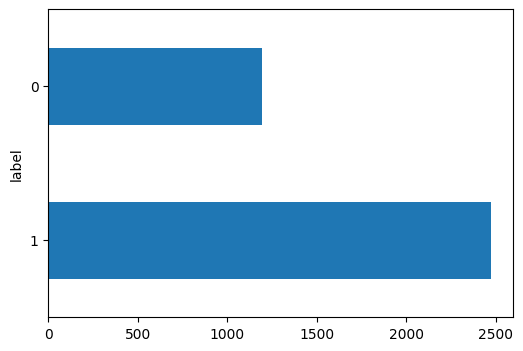

In [55]:
ax = df_train['label'].value_counts().plot(kind='barh', figsize=(6, 4))

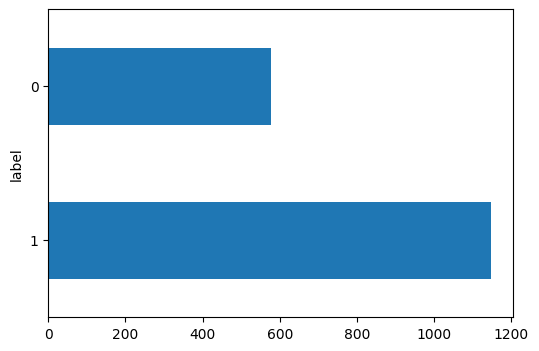

In [57]:
ax = df_test['label'].value_counts().plot(kind='barh', figsize=(6, 4))

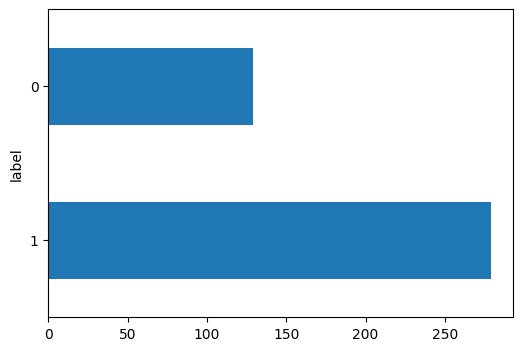

In [56]:
ax = df_validation['label'].value_counts().plot(kind='barh', figsize=(6, 4))

In [58]:
df_train.head()

,sentence1,sentence2,label
0,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr...",1
1,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...,0
2,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ...",1
3,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set...",0
4,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...,1


### Fine Tuning

In [7]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [8]:

out_dir ='./fine_tuning'
training_args = TrainingArguments(output_dir=out_dir,
                                   evaluation_strategy="steps",
                                   overwrite_output_dir=True,
                                   save_total_limit=1,
                                   run_name='fine_tuning',
                                   num_train_epochs=10,                                   
                                   report_to="none",#no wandb api log
                                   auto_find_batch_size=True,                                                                      
                                   push_to_hub=False)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

/home/carina/anaconda3/envs/hugging_face_env/lib/python3.9/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics      
)

In [10]:
trainer.train()

 11%|█         | 500/4590 [01:20<11:01,  6.18it/s]

{'loss': 0.5393, 'grad_norm': 38.21265411376953, 'learning_rate': 4.4553376906318085e-05, 'epoch': 1.09}


                                                  
 11%|█         | 500/4590 [01:22<11:01,  6.18it/s]

{'eval_loss': 0.5323272943496704, 'eval_accuracy': 0.8112745098039216, 'eval_runtime': 1.9329, 'eval_samples_per_second': 211.085, 'eval_steps_per_second': 26.386, 'epoch': 1.09}


 22%|██▏       | 1000/4590 [02:44<09:24,  6.36it/s] 

{'loss': 0.3406, 'grad_norm': 0.2138906717300415, 'learning_rate': 3.910675381263617e-05, 'epoch': 2.18}


                                                   
 22%|██▏       | 1000/4590 [02:46<09:24,  6.36it/s]

{'eval_loss': 0.784001350402832, 'eval_accuracy': 0.8308823529411765, 'eval_runtime': 1.9285, 'eval_samples_per_second': 211.565, 'eval_steps_per_second': 26.446, 'epoch': 2.18}


 33%|███▎      | 1500/4590 [04:08<08:07,  6.34it/s]  

{'loss': 0.2183, 'grad_norm': 29.915882110595703, 'learning_rate': 3.366013071895425e-05, 'epoch': 3.27}


                                                   
 33%|███▎      | 1500/4590 [04:10<08:07,  6.34it/s]

{'eval_loss': 0.7193546891212463, 'eval_accuracy': 0.8382352941176471, 'eval_runtime': 1.9338, 'eval_samples_per_second': 210.983, 'eval_steps_per_second': 26.373, 'epoch': 3.27}


 44%|████▎     | 2000/4590 [05:33<07:22,  5.85it/s]

{'loss': 0.1339, 'grad_norm': 0.154747873544693, 'learning_rate': 2.8213507625272335e-05, 'epoch': 4.36}


                                                   
 44%|████▎     | 2000/4590 [05:35<07:22,  5.85it/s]

{'eval_loss': 0.7902935147285461, 'eval_accuracy': 0.8431372549019608, 'eval_runtime': 1.9321, 'eval_samples_per_second': 211.174, 'eval_steps_per_second': 26.397, 'epoch': 4.36}


 54%|█████▍    | 2500/4590 [06:58<05:28,  6.36it/s]

{'loss': 0.0629, 'grad_norm': 0.056046389043331146, 'learning_rate': 2.2766884531590417e-05, 'epoch': 5.45}


                                                   
 54%|█████▍    | 2500/4590 [07:00<05:28,  6.36it/s]

{'eval_loss': 0.9811592698097229, 'eval_accuracy': 0.8333333333333334, 'eval_runtime': 1.9414, 'eval_samples_per_second': 210.158, 'eval_steps_per_second': 26.27, 'epoch': 5.45}


 65%|██████▌   | 3000/4590 [08:23<04:31,  5.85it/s]

{'loss': 0.0404, 'grad_norm': 0.02627807855606079, 'learning_rate': 1.7320261437908496e-05, 'epoch': 6.54}


                                                   
 65%|██████▌   | 3000/4590 [08:25<04:31,  5.85it/s]

{'eval_loss': 1.0171966552734375, 'eval_accuracy': 0.8308823529411765, 'eval_runtime': 1.935, 'eval_samples_per_second': 210.852, 'eval_steps_per_second': 26.356, 'epoch': 6.54}


 76%|███████▋  | 3500/4590 [09:48<02:55,  6.19it/s]

{'loss': 0.0228, 'grad_norm': 0.015340976417064667, 'learning_rate': 1.187363834422658e-05, 'epoch': 7.63}


                                                   
 76%|███████▋  | 3500/4590 [09:50<02:55,  6.19it/s]

{'eval_loss': 1.133531928062439, 'eval_accuracy': 0.8357843137254902, 'eval_runtime': 1.9387, 'eval_samples_per_second': 210.445, 'eval_steps_per_second': 26.306, 'epoch': 7.63}


 87%|████████▋ | 4000/4590 [11:13<01:33,  6.32it/s]

{'loss': 0.0178, 'grad_norm': 0.010821069590747356, 'learning_rate': 6.427015250544663e-06, 'epoch': 8.71}


                                                   
 87%|████████▋ | 4000/4590 [11:15<01:33,  6.32it/s]

{'eval_loss': 1.154373049736023, 'eval_accuracy': 0.8382352941176471, 'eval_runtime': 1.9419, 'eval_samples_per_second': 210.107, 'eval_steps_per_second': 26.263, 'epoch': 8.71}


 98%|█████████▊| 4500/4590 [12:38<00:15,  5.79it/s]

{'loss': 0.0078, 'grad_norm': 0.009183933958411217, 'learning_rate': 9.80392156862745e-07, 'epoch': 9.8}


                                                   
 98%|█████████▊| 4500/4590 [12:40<00:15,  5.79it/s]

{'eval_loss': 1.1627585887908936, 'eval_accuracy': 0.8431372549019608, 'eval_runtime': 1.9672, 'eval_samples_per_second': 207.401, 'eval_steps_per_second': 25.925, 'epoch': 9.8}


100%|██████████| 4590/4590 [12:58<00:00,  5.90it/s]

{'train_runtime': 778.5947, 'train_samples_per_second': 47.111, 'train_steps_per_second': 5.895, 'train_loss': 0.1508830650829282, 'epoch': 10.0}


TrainOutput(global_step=4590, training_loss=0.1508830650829282, metrics={'train_runtime': 778.5947, 'train_samples_per_second': 47.111, 'train_steps_per_second': 5.895, 'total_flos': 1353042435523440.0, 'train_loss': 0.1508830650829282, 'epoch': 10.0})

##### Model Validation

In [11]:
trainer.evaluate()

100%|██████████| 51/51 [00:01<00:00, 26.64it/s]


{'eval_loss': 1.1681450605392456,
 'eval_accuracy': 0.8431372549019608,
 'eval_runtime': 1.9527,
 'eval_samples_per_second': 208.947,
 'eval_steps_per_second': 26.118,
 'epoch': 10.0}

In [24]:
predictions = trainer.predict(tokenized_datasets['test'])

312it [00:18, 17.26it/s]                         


In [59]:
y_true = tokenized_datasets['test']['label']
y_pred = predictions.predictions.argmax(-1)

In [64]:
f1 = np.round(f1_score(y_true,y_pred), 2)
precision = np.round(precision_score(y_true,y_pred), 2)
recall = np.round(recall_score(y_true,y_pred), 2)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

print(classification_report(y_true, y_pred))

Precision: 0.84
Recall: 0.89
F1 Score: 0.86
              precision    recall  f1-score   support

           0       0.76      0.66      0.70       578
           1       0.84      0.89      0.86      1147

    accuracy                           0.81      1725
   macro avg       0.80      0.78      0.78      1725
weighted avg       0.81      0.81      0.81      1725



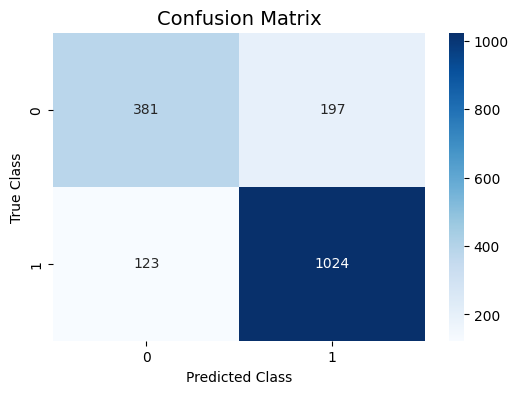

In [69]:
target_names = model.config.id2label.keys()
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

##### Predictions Analysis

In [62]:
df_test['predicted'] = y_pred

In [72]:
df_test[df_test['label'] == df_test['predicted']].sample(10)

,sentence1,sentence2,label,predicted
1312,"Ultimately , however , Mrs Clinton decided she...",She says she stayed in the marriage because sh...,1,1
606,The findings are published in the November 6 e...,Both studies are published on Thursday in Natu...,1,1
789,""" Each institution helped Enron mislead its in...",The SEC said each bank helped Enron mislead in...,1,1
794,The industry 's largest association is urging ...,"Meantime , the Direct Marketing Association sa...",1,1
1168,The government began on September 1 to add the...,The government recently added the word ' Taiwa...,1,1
418,Cadbury Schweppes plc plans to cut 5500 jobs a...,Cadbury Schweppes has unveiled plans to slash ...,1,1
1418,The state wanted every insurer doing business ...,The state wanted any insurer doing business th...,1,1
113,"Judge Gerald W. Heaney , in dissent , said the...","In dissent , Judge Gerald W. Heaney said the a...",1,1
77,"Customers that pay the $ 1,219 entrance fee ge...",Retail pricing for SMS 2003 with 10 device cli...,1,1
906,""" It is wasting both water and money , "" Orteg...",""" It 's a waste of water and money , "" said Ad...",1,1
